<h2 align=center> Facial Expression Recognition with Keras</h2>

### Task 1: Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


Tensorflow version: 2.15.0


In [2]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+expression))) + " " + expression + " images")

3993 angry images
436 disgust images
4103 fear images
7164 happy images
4982 neutral images
4938 sad images
3205 surprise images


### Task 2: Generate Training and Validation Batches

In [3]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size =(img_size, img_size),
                                                    batch_size =batch_size,
                                                    color_mode='grayscale',
                                                    class_mode='categorical',
                                                    shuffle = True)
datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_validation.flow_from_directory("validation/",
                                                    target_size =(img_size, img_size),
                                                    batch_size =batch_size,
                                                    color_mode='grayscale',
                                                    class_mode='categorical',
                                                    shuffle = True)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


### Task 3: Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [4]:
# 1st conv
model = Sequential()
model.add(Conv2D(64, (3,3) ,padding = "same",input_shape =(48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# 2nd conv
model.add(Conv2D(128, (5,5) ,padding = "same",))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# 3rd conv
model.add(Conv2D(512, (3,3) ,padding = "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))


# 4th conv

model.add(Conv2D(512, (3,3) ,padding = "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# flattening
model.add(Flatten())

# 1st fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))

# 2nd fully connencted layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
                    
# last dense layer
model.add(Dense(7, activation = "softmax"))
opt = Adam(learning_rate = 0.0005)

model.compile(optimizer= opt,loss= 'categorical_crossentropy',metrics = ["accuracy"])
model.summary()
          



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)      

### Task 5: Train and Evaluate Model

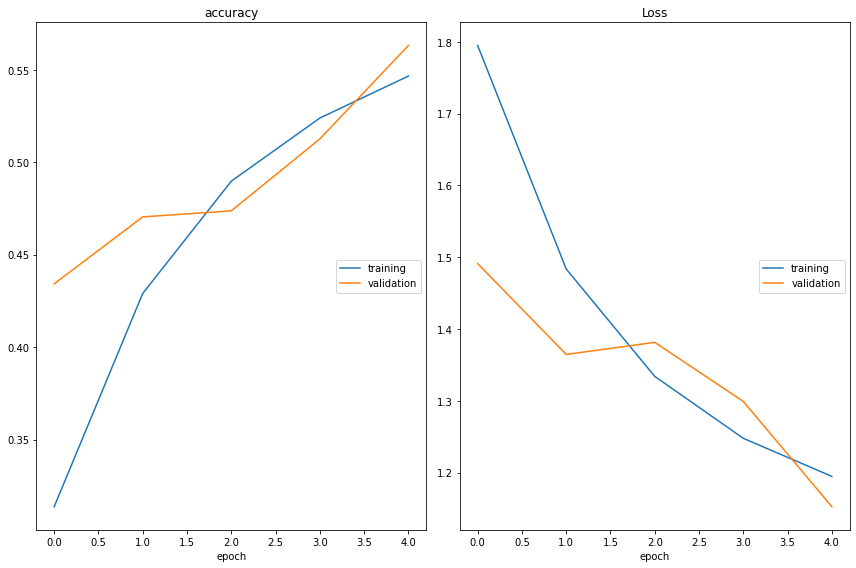

accuracy
	training         	 (min:    0.314, max:    0.547, cur:    0.547)
	validation       	 (min:    0.434, max:    0.563, cur:    0.563)
Loss
	training         	 (min:    1.195, max:    1.795, cur:    1.195)
	validation       	 (min:    1.153, max:    1.491, cur:    1.153)

Epoch 5: saving model to model_weights.h5
450/450 [==============================] - 287s 639ms/step - loss: 1.1948 - accuracy: 0.5466 - val_loss: 1.1525 - val_accuracy: 0.5632 - lr: 5.0000e-04


In [5]:
epochs = 5
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5",monitor = "val_accuracy",
                             save_weights_only = True,mode = "max", verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss" , factor = 0.1, patience = 2, min_lr = 0.00001,model = "auto")

callbacks = [PlotLossesCallback(),checkpoint,reduce_lr]

history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    validation_data = validation_generator,
    epochs = epochs,
    validation_steps = validation_steps,
    callbacks = callbacks
)


### Task 6: Represent Model as JSON String

In [26]:
model_json = model.to_json()
with open ("model.json", "w") as json_file:
    json_file.write(model_json)